In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import murmurhash3_32
from random import randint
import csv
import sys
from sklearn.metrics import roc_curve, auc

In [2]:
def hashfunc(m):
    ss = randint(1, 99999999)
    def hash_m(x):
        return murmurhash3_32(x,seed=ss)%m
    return hash_m

In [3]:
class BloomFilter():
    def __init__(self, n, hash_len, k = None):
        self.n = n
        self.hash_len = int(hash_len)
        if k == None:
            self.k = int(self.hash_len/n*0.6931472)
        else:
            self.k = k
        self.h = []
        for i in range(self.k):
            self.h.append(hashfunc(self.hash_len))
        self.table = np.zeros(self.hash_len, dtype=int)
    def insert(self, key):
        for i in key:
            for j in range(self.k):
                t = self.h[j](i)
                self.table[t] = 1
    def test(self, key):
        test_result = np.zeros(len(key))
        ss=0
        for i in key:
            match = 0
            for j in range(self.k):
                t = self.h[j](i)
                match += 1*(self.table[t] == 1)
            if match == self.k:
                test_result[ss] = 1
            ss += 1  
        return test_result

In [4]:
class BloomFilter_2():
    def __init__(self, n, hash_len, k_max):
        self.n = n
        self.hash_len = int(hash_len)
        self.h = []
        for i in range(int(k_max)):
            self.h.append(hashfunc(self.hash_len))
        self.table = np.zeros(self.hash_len, dtype=int)
    def insert(self, key, k):
        for j in range(int(k)):
            t = self.h[j](key)
            self.table[t] = 1
    def test(self, key, k):
        test_result = 0
        match = 0
        for j in range(int(k)):
            t = self.h[j](key)
            match += 1*(self.table[t] == 1)
        if match == k:
            test_result = 1
        return test_result

In [5]:
class BloomFilter_3():
    def __init__(self, n, hash_len):
        self.n = n
        self.hash_len = int(hash_len)
        self.k = np.round(self.hash_len/n*0.6931472)
        self.h = []
        for i in range(self.k.astype(int)):
            self.h.append(hashfunc(self.hash_len))
        self.table = np.zeros(self.hash_len, dtype=int)
    def insert(self, key):
        for i in key:
            for j in range(self.k.astype(int)):
                t = self.h[j](i)
                self.table[t] = 1
    def test(self, key):
        test_result = 0
        match = 0
        for j in range(self.k.astype(int)):
            t = self.h[j](key)
            match += 1*(self.table[t] == 1)
        if match == self.k.astype(int):
            test_result = 1  
        return test_result

In [6]:
### Adaboost, n_estimator = 40, learning_rate = 0.05, 30% training data
train_data = pd.read_csv('C:/COMP 580/Malware Detection/Machine-Learning-approach-for-Malware-Detection-master/model fitted result 3.csv')
# train_data = pd.read_csv('C:/COMP 580/Malware Detection/Machine-Learning-approach-for-Malware-Detection-master/model fitted result (train).csv')
test_data = pd.read_csv('C:/COMP 580/Malware Detection/Machine-Learning-approach-for-Malware-Detection-master/model fitted result (test).csv')

train_negative = train_data.loc[(train_data.loc[:,'label']==0),:]
train_positive = train_data.loc[(train_data.loc[:,'label']==1),:]

test_negative = test_data.loc[(test_data.loc[:,'label']==0),:]
test_positive = test_data.loc[(test_data.loc[:,'label']==1),:]

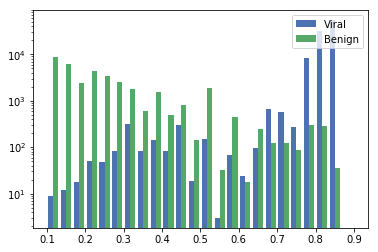

In [19]:
plt.style.use('seaborn-deep')

x = train_data.loc[train_data.loc[:,'label']==1,'score']
y = train_data.loc[train_data.loc[:,'label']==0,'score']
bins = np.linspace(0.1, 0.9, 25)

plt.hist([x, y], bins, log=True, label=['Viral', 'Benign'])
plt.legend(loc='upper right')
plt.show()

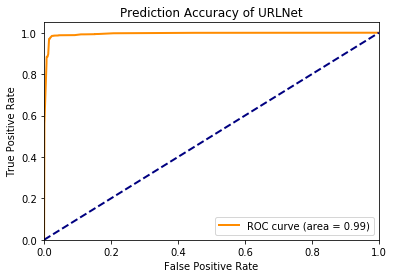

In [9]:
fpr, tpr, _ = roc_curve(train_data.loc[:,'label'], train_data.loc[:,'score'])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Prediction Accuracy of URLNet')
plt.legend(loc="lower right")
plt.show()

## <font color='red'> Original ML based Bloom Filter</font>


#### First Round: Briefly search the optimal threshold (Hash_len = 100000)

In [11]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.3, 0.85, 12)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 100000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  8943.0
False positive items:  6900.0
False positive items:  4992.0
False positive items:  3789.0
False positive items:  3529.0
False positive items:  1671.0
False positive items:  1212.0
False positive items:  955.0
False positive items:  828.0
False positive items:  673.0
False positive items:  858.0
False positive items:  14136.0


#### Second Round: Detaily search the optimal threshold (Hash_len = 100000)

In [90]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.75, 0.80, 11)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 100000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  673.0
False positive items:  671.0
False positive items:  616.0
False positive items:  616.0
False positive items:  763.0
False positive items:  776.0
False positive items:  815.0
False positive items:  887.0
False positive items:  919.0
False positive items:  875.0
False positive items:  904.0


#### Corresponding on testing data (Hash_len = 100000)

In [45]:
## Control FPR = 0.001 in the training data
threshold = 0.76

hash_len = 100000
url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
n = len(url)
bloom_filter = BloomFilter(n, hash_len)
bloom_filter.insert(url)
ML_positive = test_negative.loc[(test_negative.loc[:,'score'] > threshold),'md5']
bloom_negative = test_negative.loc[(test_negative.loc[:,'score'] <= threshold),'md5']
n1 = bloom_filter.test(bloom_negative)
print('False positive items: ', sum(n1) + len(ML_positive))
print('False positive Rate: ', (sum(n1) + len(ML_positive))/test_negative.shape[0])

False positive items:  229.0
False positive Rate:  0.013935373942676322


#### First Round: Briefly search the optimal threshold (Hash_len = 150000)

In [13]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.5, 0.85, 8)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 150000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  3529.0
False positive items:  1671.0
False positive items:  1212.0
False positive items:  955.0
False positive items:  828.0
False positive items:  673.0
False positive items:  397.0
False positive items:  8114.0


#### Second Round: Detaily search the optimal threshold (Hash_len = 150000)

In [96]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.70, 0.80, 11)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 150000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  828.0
False positive items:  776.0
False positive items:  774.0
False positive items:  703.0
False positive items:  676.0
False positive items:  673.0
False positive items:  616.0
False positive items:  536.0
False positive items:  549.0
False positive items:  394.0
False positive items:  373.0


In [98]:
print(n)
sum(n1)

11236


51.0

#### First Round: Briefly search the optimal threshold (Hash_len = 200000)

In [15]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.5, 0.85, 8)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 200000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  3529.0
False positive items:  1671.0
False positive items:  1212.0
False positive items:  955.0
False positive items:  828.0
False positive items:  673.0
False positive items:  329.0
False positive items:  4544.0


#### Second Round: Detaily search the optimal threshold (Hash_len = 200000)

In [16]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.75, 0.85, 11)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 200000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  673.0
False positive items:  616.0
False positive items:  519.0
False positive items:  520.0
False positive items:  324.0
False positive items:  327.0
False positive items:  319.0
False positive items:  4293.0
False positive items:  4380.0
False positive items:  4417.0
False positive items:  4771.0


#### First Round: Briefly search the optimal threshold (Hash_len = 250000)

In [17]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.5, 0.85, 8)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 250000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  3529.0
False positive items:  1671.0
False positive items:  1212.0
False positive items:  955.0
False positive items:  828.0
False positive items:  673.0
False positive items:  323.0
False positive items:  2717.0


#### Second Round: Detaily search the optimal threshold (Hash_len = 250000)

In [79]:
## Control FPR = 0.001 in the training data
thresholds = np.linspace(0.77, 0.82, 11)
FPR_count = np.zeros(len(thresholds))
ss = 0

hash_len = 250000
for threshold in thresholds:
    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n = len(url)
    bloom_filter = BloomFilter(n, hash_len)
    bloom_filter.insert(url)
    ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > threshold),'md5']
    bloom_negative = train_negative.loc[(train_negative.loc[:,'score'] <= threshold),'md5']
    n1 = bloom_filter.test(bloom_negative)
    print('False positive items: ', sum(n1) + len(ML_positive))
    FPR_count[ss] = sum(n1) + len(ML_positive)
    ss += 1

False positive items:  519.0
False positive items:  519.0
False positive items:  519.0
False positive items:  323.0
False positive items:  322.0
False positive items:  322.0
False positive items:  322.0
False positive items:  323.0
False positive items:  304.0
False positive items:  311.0
False positive items:  2466.0


## <font color='red'> Sandwiching ML based Bloom Filter</font>

#### Performance of training data (Hash_len = 100000)

In [71]:
thresholds = np.linspace(0.70, 0.80, 11)

for threshold in thresholds:
    url_raw = train_positive.loc[:,'md5']
    n = len(url_raw)
    hash_len1 = 20000
    bloom_filter1 = BloomFilter(n, hash_len1)
    bloom_filter1.insert(url_raw)

    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n2 = len(url)
    hash_len2 = 80000
    bloom_filter2 = BloomFilter(n2, hash_len2)
    bloom_filter2.insert(url)

    negative_url_raw = train_negative.loc[:,'md5']
    negative_score_raw = train_negative.loc[:,'score']
    test_result = bloom_filter1.test(negative_url_raw)


    negative_url_filtered = negative_url_raw[test_result==1]
    negative_score_filtered = negative_score_raw[test_result==1]
    bloom_negative = negative_url_filtered[negative_score_filtered <= threshold]
    ML_positive = negative_url_filtered[negative_score_filtered > threshold]

    test_result2 = bloom_filter2.test(bloom_negative)
    print('False positive items: ', sum(test_result2) + len(ML_positive))

False positive items:  828.0
False positive items:  776.0
False positive items:  774.0
False positive items:  703.0
False positive items:  676.0
False positive items:  673.0
False positive items:  616.0
False positive items:  1139.0
False positive items:  1327.0
False positive items:  1762.0
False positive items:  1649.0


#### Performance of training data (Hash_len = 150000)

In [75]:
thresholds = np.linspace(0.70, 0.85, 16)

for threshold in thresholds:
    url_raw = train_positive.loc[:,'md5']
    n = len(url_raw)
    hash_len1 = 30000
    bloom_filter1 = BloomFilter(n, hash_len1)
    bloom_filter1.insert(url_raw)

    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n2 = len(url)
    hash_len2 = 120000
    bloom_filter2 = BloomFilter(n2, hash_len2)
    bloom_filter2.insert(url)

    negative_url_raw = train_negative.loc[:,'md5']
    negative_score_raw = train_negative.loc[:,'score']
    test_result = bloom_filter1.test(negative_url_raw)


    negative_url_filtered = negative_url_raw[test_result==1]
    negative_score_filtered = negative_score_raw[test_result==1]
    bloom_negative = negative_url_filtered[negative_score_filtered <= threshold]
    ML_positive = negative_url_filtered[negative_score_filtered > threshold]

    test_result2 = bloom_filter2.test(bloom_negative)
    print('False positive items: ', sum(test_result2) + len(ML_positive))

False positive items:  828.0
False positive items:  776.0
False positive items:  774.0
False positive items:  703.0
False positive items:  676.0
False positive items:  673.0
False positive items:  616.0
False positive items:  608.0
False positive items:  634.0
False positive items:  576.0
False positive items:  599.0
False positive items:  690.0
False positive items:  10564.0
False positive items:  10660.0
False positive items:  10798.0
False positive items:  11114.0


#### Performance of training data (Hash_len = 200000)

In [77]:
thresholds = np.linspace(0.70, 0.85, 16)

for threshold in thresholds:
    url_raw = train_positive.loc[:,'md5']
    n = len(url_raw)
    hash_len1 = 40000
    bloom_filter1 = BloomFilter(n, hash_len1)
    bloom_filter1.insert(url_raw)

    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n2 = len(url)
    hash_len2 = 160000
    bloom_filter2 = BloomFilter(n2, hash_len2)
    bloom_filter2.insert(url)

    negative_url_raw = train_negative.loc[:,'md5']
    negative_score_raw = train_negative.loc[:,'score']
    test_result = bloom_filter1.test(negative_url_raw)


    negative_url_filtered = negative_url_raw[test_result==1]
    negative_score_filtered = negative_score_raw[test_result==1]
    bloom_negative = negative_url_filtered[negative_score_filtered <= threshold]
    ML_positive = negative_url_filtered[negative_score_filtered > threshold]

    test_result2 = bloom_filter2.test(bloom_negative)
    print('False positive items: ', sum(test_result2) + len(ML_positive))

False positive items:  828.0
False positive items:  776.0
False positive items:  774.0
False positive items:  703.0
False positive items:  676.0
False positive items:  673.0
False positive items:  616.0
False positive items:  535.0
False positive items:  538.0
False positive items:  366.0
False positive items:  353.0
False positive items:  389.0
False positive items:  6839.0
False positive items:  6736.0
False positive items:  6927.0
False positive items:  7422.0


#### Performance of training data (Hash_len = 250000)

In [78]:
thresholds = np.linspace(0.70, 0.85, 16)

for threshold in thresholds:
    url_raw = train_positive.loc[:,'md5']
    n = len(url_raw)
    hash_len1 = 50000
    bloom_filter1 = BloomFilter(n, hash_len1)
    bloom_filter1.insert(url_raw)

    url = train_positive.loc[(train_positive.loc[:,'score'] <= threshold),'md5']
    n2 = len(url)
    hash_len2 = 200000
    bloom_filter2 = BloomFilter(n2, hash_len2)
    bloom_filter2.insert(url)

    negative_url_raw = train_negative.loc[:,'md5']
    negative_score_raw = train_negative.loc[:,'score']
    test_result = bloom_filter1.test(negative_url_raw)


    negative_url_filtered = negative_url_raw[test_result==1]
    negative_score_filtered = negative_score_raw[test_result==1]
    bloom_negative = negative_url_filtered[negative_score_filtered <= threshold]
    ML_positive = negative_url_filtered[negative_score_filtered > threshold]

    test_result2 = bloom_filter2.test(bloom_negative)
    print('False positive items: ', sum(test_result2) + len(ML_positive))

False positive items:  828.0
False positive items:  776.0
False positive items:  774.0
False positive items:  703.0
False positive items:  676.0
False positive items:  673.0
False positive items:  616.0
False positive items:  520.0
False positive items:  519.0
False positive items:  326.0
False positive items:  329.0
False positive items:  317.0
False positive items:  4338.0
False positive items:  4309.0
False positive items:  4449.0
False positive items:  4758.0


## <font color='red'> Enhanced Version of ML based Bloom Filter</font>

#### Search Optimal k_max and c (Hash_len = 100000)

In [19]:
c_set = np.linspace(1.4, 2.3, 10)

R_sum = 100000

for num_group in range(5,10):
    for c in c_set:
        ### Determine the thresholds
        thresholds = np.zeros(num_group+1)
        thresholds[0] = 0
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        tau = sum(c**np.arange(0, num_group, 1)) 
        num_piece = int(num_negative/tau)
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for i in range(num_group-1):
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        
        ### Count the keys of each group
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        count_key = np.zeros(num_group)
        url_group = []
        bloom_filter = []
        for j in range(int(num_group)):
            count_key[j] = sum((score >= thresholds[j]) & (score < thresholds[j+1]))
            url_group.append(url[(score >= thresholds[j]) & (score < thresholds[j+1])])
            
        ### Search the Bloom filters' size
        R = np.zeros(num_group - 1)
        R[:] = 0.5*R_sum
        kk = 1
        while abs(sum(R)-R_sum)>200:
            if (sum(R)>R_sum):
                R[0] = R[0] - int((0.5*R_sum)*(0.5)**kk+1)
            else:
                R[0] = R[0] + int((0.5*R_sum)*(0.5)**kk+1)
            for j in range(1, int(num_group-1)):
                R[j] = max(int(count_key[j]*(R[0]/count_key[0]+j*np.log(c)/np.log(0.618))),1)
            if int((0.5*R_sum)*(0.5)**kk+1) == 1:
                break
            kk += 1
        
        Bloom_Filters = []
        for j in range(int(num_group-1)):
            Bloom_Filters.append(BloomFilter_3(count_key[j], R[j]))
            Bloom_Filters[j].insert(url_group[j])
            
        ### Test URLs
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] >= thresholds[-2]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s < thresholds)[0])
            test_result[ss] = Bloom_Filters[ix-1].test(url_s)
            ss += 1
        print('False positive items: ', [num_group, c], sum(test_result)+len(ML_positive))

False positive items:  [5, 1.4] 3789.0
False positive items:  [5, 1.5] 3255.0
False positive items:  [5, 1.5999999999999999] 3255.0
False positive items:  [5, 1.7] 3255.0
False positive items:  [5, 1.7999999999999998] 3255.0
False positive items:  [5, 1.9] 1570.0
False positive items:  [5, 2.0] 1479.0
False positive items:  [5, 2.0999999999999996] 1182.0
False positive items:  [5, 2.1999999999999997] 1067.0
False positive items:  [5, 2.3] 851.0
False positive items:  [6, 1.4] 3255.0
False positive items:  [6, 1.5] 3255.0
False positive items:  [6, 1.5999999999999999] 1573.0
False positive items:  [6, 1.7] 1479.0
False positive items:  [6, 1.7999999999999998] 1067.0
False positive items:  [6, 1.9] 828.0
False positive items:  [6, 2.0] 671.0
False positive items:  [6, 2.0999999999999996] 605.0
False positive items:  [6, 2.1999999999999997] 557.0
False positive items:  [6, 2.3] 514.0
False positive items:  [7, 1.4] 1789.0
False positive items:  [7, 1.5] 1479.0
False positive items:  [7, 1

C:\Users\daizw\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


False positive items:  [8, 2.0999999999999996] 446.0
False positive items:  [8, 2.1999999999999997] 458.0
False positive items:  [8, 2.3] 449.0
False positive items:  [9, 1.4] 845.0
False positive items:  [9, 1.5] 605.0
False positive items:  [9, 1.5999999999999999] 495.0
False positive items:  [9, 1.7] 504.0
False positive items:  [9, 1.7999999999999998] 485.0
False positive items:  [9, 1.9] 476.0
False positive items:  [9, 2.0] 452.0
False positive items:  [9, 2.0999999999999996] 438.0
False positive items:  [9, 2.1999999999999997] 473.0
False positive items:  [9, 2.3] 567.0


#### Search Optimal k_max and c (Hash_len = 150000)

In [20]:
c_set = np.linspace(1.4, 2.3, 10)

R_sum = 150000

for num_group in range(6,11):
    for c in c_set:
        ### Determine the thresholds
        thresholds = np.zeros(num_group+1)
        thresholds[0] = 0
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        tau = sum(c**np.arange(0, num_group, 1)) 
        num_piece = int(num_negative/tau)
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for i in range(num_group-1):
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        
        ### Count the keys of each group
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        count_key = np.zeros(num_group)
        url_group = []
        bloom_filter = []
        for j in range(int(num_group)):
            count_key[j] = sum((score >= thresholds[j]) & (score < thresholds[j+1]))
            url_group.append(url[(score >= thresholds[j]) & (score < thresholds[j+1])])
            
        ### Search the Bloom filters' size
        R = np.zeros(num_group - 1)
        R[:] = 0.5*R_sum
        kk = 1
        while abs(sum(R)-R_sum)>200:
            if (sum(R)>R_sum):
                R[0] = R[0] - int((0.5*R_sum)*(0.5)**kk+1)
            else:
                R[0] = R[0] + int((0.5*R_sum)*(0.5)**kk+1)
            for j in range(1, int(num_group-1)):
                R[j] = max(int(count_key[j]*(R[0]/count_key[0]+j*np.log(c)/np.log(0.618))),1)
            if int((0.5*R_sum)*(0.5)**kk+1) == 1:
                break
            kk += 1
        
        Bloom_Filters = []
        for j in range(int(num_group-1)):
            Bloom_Filters.append(BloomFilter_3(count_key[j], R[j]))
            Bloom_Filters[j].insert(url_group[j])
            
        ### Test URLs
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] >= thresholds[-2]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s < thresholds)[0])
            test_result[ss] = Bloom_Filters[ix-1].test(url_s)
            ss += 1
        print('False positive items: ', [num_group, c], sum(test_result)+len(ML_positive))

False positive items:  [6, 1.4] 3255.0
False positive items:  [6, 1.5] 3255.0
False positive items:  [6, 1.5999999999999999] 1573.0
False positive items:  [6, 1.7] 1479.0
False positive items:  [6, 1.7999999999999998] 1067.0
False positive items:  [6, 1.9] 828.0
False positive items:  [6, 2.0] 671.0
False positive items:  [6, 2.0999999999999996] 605.0
False positive items:  [6, 2.1999999999999997] 523.0
False positive items:  [6, 2.3] 430.0
False positive items:  [7, 1.4] 1789.0
False positive items:  [7, 1.5] 1479.0
False positive items:  [7, 1.5999999999999999] 1067.0
False positive items:  [7, 1.7] 774.0
False positive items:  [7, 1.7999999999999998] 605.0
False positive items:  [7, 1.9] 434.0
False positive items:  [7, 2.0] 429.0
False positive items:  [7, 2.0999999999999996] 330.0
False positive items:  [7, 2.1999999999999997] 325.0
False positive items:  [7, 2.3] 316.0
False positive items:  [8, 1.4] 1205.0
False positive items:  [8, 1.5] 845.0
False positive items:  [8, 1.599999

C:\Users\daizw\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


False positive items:  [8, 2.0999999999999996] 325.0
False positive items:  [8, 2.1999999999999997] 334.0
False positive items:  [8, 2.3] 324.0
False positive items:  [9, 1.4] 845.0
False positive items:  [9, 1.5] 605.0
False positive items:  [9, 1.5999999999999999] 431.0
False positive items:  [9, 1.7] 340.0
False positive items:  [9, 1.7999999999999998] 329.0
False positive items:  [9, 1.9] 327.0
False positive items:  [9, 2.0] 323.0
False positive items:  [9, 2.0999999999999996] 331.0
False positive items:  [9, 2.1999999999999997] 328.0
False positive items:  [9, 2.3] 279.0
False positive items:  [10, 1.4] 605.0
False positive items:  [10, 1.5] 433.0
False positive items:  [10, 1.5999999999999999] 338.0
False positive items:  [10, 1.7] 337.0
False positive items:  [10, 1.7999999999999998] 325.0
False positive items:  [10, 1.9] 325.0
False positive items:  [10, 2.0] 327.0
False positive items:  [10, 2.0999999999999996] 310.0
False positive items:  [10, 2.1999999999999997] 352.0
False

#### Search Optimal k_max and c (Hash_len = 200000)

In [21]:
c_set = np.linspace(1.4, 2.3, 10)

R_sum = 200000

for num_group in range(7,12):
    for c in c_set:
        ### Determine the thresholds
        thresholds = np.zeros(num_group+1)
        thresholds[0] = 0
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        tau = sum(c**np.arange(0, num_group, 1)) 
        num_piece = int(num_negative/tau)
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for i in range(num_group-1):
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        
        ### Count the keys of each group
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        count_key = np.zeros(num_group)
        url_group = []
        bloom_filter = []
        for j in range(int(num_group)):
            count_key[j] = sum((score >= thresholds[j]) & (score < thresholds[j+1]))
            url_group.append(url[(score >= thresholds[j]) & (score < thresholds[j+1])])
            
        ### Search the Bloom filters' size
        R = np.zeros(num_group - 1)
        R[:] = 0.5*R_sum
        kk = 1
        while abs(sum(R)-R_sum)>200:
            if (sum(R)>R_sum):
                R[0] = R[0] - int((0.5*R_sum)*(0.5)**kk+1)
            else:
                R[0] = R[0] + int((0.5*R_sum)*(0.5)**kk+1)
            for j in range(1, int(num_group-1)):
                R[j] = max(int(count_key[j]*(R[0]/count_key[0]+j*np.log(c)/np.log(0.618))),1)
            if int((0.5*R_sum)*(0.5)**kk+1) == 1:
                break
            kk += 1
        
        Bloom_Filters = []
        for j in range(int(num_group-1)):
            Bloom_Filters.append(BloomFilter_3(count_key[j], R[j]))
            Bloom_Filters[j].insert(url_group[j])
            
        ### Test URLs
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] >= thresholds[-2]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s < thresholds)[0])
            test_result[ss] = Bloom_Filters[ix-1].test(url_s)
            ss += 1
        print('False positive items: ', [num_group, c], sum(test_result)+len(ML_positive))

False positive items:  [7, 1.4] 1789.0
False positive items:  [7, 1.5] 1479.0
False positive items:  [7, 1.5999999999999999] 1067.0
False positive items:  [7, 1.7] 774.0
False positive items:  [7, 1.7999999999999998] 605.0
False positive items:  [7, 1.9] 427.0
False positive items:  [7, 2.0] 426.0
False positive items:  [7, 2.0999999999999996] 306.0
False positive items:  [7, 2.1999999999999997] 303.0
False positive items:  [7, 2.3] 308.0
False positive items:  [8, 1.4] 1205.0
False positive items:  [8, 1.5] 845.0
False positive items:  [8, 1.5999999999999999] 605.0
False positive items:  [8, 1.7] 428.0
False positive items:  [8, 1.7999999999999998] 306.0
False positive items:  [8, 1.9] 302.0
False positive items:  [8, 2.0] 305.0


C:\Users\daizw\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


False positive items:  [8, 2.0999999999999996] 309.0
False positive items:  [8, 2.1999999999999997] 314.0
False positive items:  [8, 2.3] 304.0
False positive items:  [9, 1.4] 845.0
False positive items:  [9, 1.5] 605.0
False positive items:  [9, 1.5999999999999999] 427.0
False positive items:  [9, 1.7] 305.0
False positive items:  [9, 1.7999999999999998] 307.0
False positive items:  [9, 1.9] 304.0
False positive items:  [9, 2.0] 304.0
False positive items:  [9, 2.0999999999999996] 308.0
False positive items:  [9, 2.1999999999999997] 302.0
False positive items:  [9, 2.3] 198.0
False positive items:  [10, 1.4] 605.0
False positive items:  [10, 1.5] 428.0
False positive items:  [10, 1.5999999999999999] 306.0
False positive items:  [10, 1.7] 308.0
False positive items:  [10, 1.7999999999999998] 309.0
False positive items:  [10, 1.9] 304.0
False positive items:  [10, 2.0] 304.0
False positive items:  [10, 2.0999999999999996] 171.0
False positive items:  [10, 2.1999999999999997] 204.0
False

#### Search Optimal k_max and c (Hash_len = 250000)

In [22]:
c_set = np.linspace(1.4, 2.3, 10)

R_sum = 250000

for num_group in range(7,12):
    for c in c_set:
        ### Determine the thresholds
        thresholds = np.zeros(num_group+1)
        thresholds[0] = 0
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        tau = sum(c**np.arange(0, num_group, 1)) 
        num_piece = int(num_negative/tau)
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for i in range(num_group-1):
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        
        ### Count the keys of each group
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        count_key = np.zeros(num_group)
        url_group = []
        bloom_filter = []
        for j in range(int(num_group)):
            count_key[j] = sum((score >= thresholds[j]) & (score < thresholds[j+1]))
            url_group.append(url[(score >= thresholds[j]) & (score < thresholds[j+1])])
            
        ### Search the Bloom filters' size
        R = np.zeros(num_group - 1)
        R[:] = 0.5*R_sum
        kk = 1
        while abs(sum(R)-R_sum)>200:
            if (sum(R)>R_sum):
                R[0] = R[0] - int((0.5*R_sum)*(0.5)**kk+1)
            else:
                R[0] = R[0] + int((0.5*R_sum)*(0.5)**kk+1)
            for j in range(1, int(num_group-1)):
                R[j] = max(int(count_key[j]*(R[0]/count_key[0]+j*np.log(c)/np.log(0.618))),1)
            if int((0.5*R_sum)*(0.5)**kk+1) == 1:
                break
            kk += 1
        
        Bloom_Filters = []
        for j in range(int(num_group-1)):
            Bloom_Filters.append(BloomFilter_3(count_key[j], R[j]))
            Bloom_Filters[j].insert(url_group[j])
            
        ### Test URLs
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] >= thresholds[-2]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] < thresholds[-2]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s < thresholds)[0])
            test_result[ss] = Bloom_Filters[ix-1].test(url_s)
            ss += 1
        print('False positive items: ', [num_group, c], sum(test_result)+len(ML_positive))

False positive items:  [7, 1.4] 1789.0
False positive items:  [7, 1.5] 1479.0
False positive items:  [7, 1.5999999999999999] 1067.0
False positive items:  [7, 1.7] 774.0
False positive items:  [7, 1.7999999999999998] 605.0
False positive items:  [7, 1.9] 426.0
False positive items:  [7, 2.0] 426.0
False positive items:  [7, 2.0999999999999996] 301.0
False positive items:  [7, 2.1999999999999997] 300.0
False positive items:  [7, 2.3] 300.0
False positive items:  [8, 1.4] 1205.0
False positive items:  [8, 1.5] 845.0
False positive items:  [8, 1.5999999999999999] 605.0
False positive items:  [8, 1.7] 426.0
False positive items:  [8, 1.7999999999999998] 304.0
False positive items:  [8, 1.9] 302.0
False positive items:  [8, 2.0] 303.0


C:\Users\daizw\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


False positive items:  [8, 2.0999999999999996] 300.0
False positive items:  [8, 2.1999999999999997] 301.0
False positive items:  [8, 2.3] 300.0
False positive items:  [9, 1.4] 845.0
False positive items:  [9, 1.5] 605.0
False positive items:  [9, 1.5999999999999999] 426.0
False positive items:  [9, 1.7] 302.0
False positive items:  [9, 1.7999999999999998] 302.0
False positive items:  [9, 1.9] 301.0
False positive items:  [9, 2.0] 300.0
False positive items:  [9, 2.0999999999999996] 303.0
False positive items:  [9, 2.1999999999999997] 306.0
False positive items:  [9, 2.3] 121.0
False positive items:  [10, 1.4] 605.0
False positive items:  [10, 1.5] 426.0
False positive items:  [10, 1.5999999999999999] 305.0
False positive items:  [10, 1.7] 300.0
False positive items:  [10, 1.7999999999999998] 301.0
False positive items:  [10, 1.9] 301.0
False positive items:  [10, 2.0] 300.0
False positive items:  [10, 2.0999999999999996] 113.0
False positive items:  [10, 2.1999999999999997] 144.0
False

## <font color='red'> Enhanced Version of ML based Bloom Filter (Version 2)</font>

#### Search Optimal k_max and c (Hash_len = 100000)

In [23]:
k_min = 0
k_max_set = range(7,12)
c_set = np.linspace(1.4, 2.3, 10)
for k_max in k_max_set:
    for c in c_set:
        tau = sum(c**np.arange(0, k_max-k_min+1, 1)) 
        n = train_positive.shape[0]
        hash_len = 100000
        bloom_filter = BloomFilter_2(n, hash_len, k_max)
        thresholds = np.zeros(k_max-k_min+1)
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        num_piece = int(num_negative/tau)+1
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for k in range(k_min,k_max):
            i = k - k_min
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        for score_s, url_s in zip(score, url):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            bloom_filter.insert(url_s, k)
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > thresholds[-1]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            test_result[ss] = bloom_filter.test(url_s, k)
            ss += 1
        print('False positive items: ', [k_max, c], sum(test_result)+len(ML_positive))

False positive items:  [7, 1.4] 1230.0
False positive items:  [7, 1.5] 903.0
False positive items:  [7, 1.5999999999999999] 630.0
False positive items:  [7, 1.7] 439.0
False positive items:  [7, 1.7999999999999998] 435.0
False positive items:  [7, 1.9] 729.0
False positive items:  [7, 2.0] 718.0
False positive items:  [7, 2.0999999999999996] 2694.0
False positive items:  [7, 2.1999999999999997] 2606.0
False positive items:  [7, 2.3] 2413.0
False positive items:  [8, 1.4] 882.0
False positive items:  [8, 1.5] 627.0
False positive items:  [8, 1.5999999999999999] 444.0
False positive items:  [8, 1.7] 613.0
False positive items:  [8, 1.7999999999999998] 577.0
False positive items:  [8, 1.9] 1967.0
False positive items:  [8, 2.0] 1929.0
False positive items:  [8, 2.0999999999999996] 5859.0
False positive items:  [8, 2.1999999999999997] 5880.0
False positive items:  [8, 2.3] 13505.0
False positive items:  [9, 1.4] 635.0
False positive items:  [9, 1.5] 430.0
False positive items:  [9, 1.59999

#### Corresponding performance on the testing set (Hash_len = 100000)

In [51]:
k_min = 0
k_max = 10
c = 1.5


tau = sum(c**np.arange(0, k_max-k_min+1, 1)) 
n = train_positive.shape[0]
hash_len = 100000
bloom_filter = BloomFilter_2(n, hash_len, k_max)
thresholds = np.zeros(k_max-k_min+1)
thresholds[-1] = 1
num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
num_piece = int(num_negative/tau)+1
score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
score = np.sort(score)
for k in range(k_min,k_max):
    i = k - k_min
    score_1 = score[score<=thresholds[-(i+1)]]
    thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

for score_s, url_s in zip(score, url):
    ix = min(np.where(score_s<=thresholds)[0])
    thres = thresholds[ix]
    k = k_max - ix
    bloom_filter.insert(url_s, k)
ML_positive = test_negative.loc[(test_negative.loc[:,'score'] > thresholds[-1]),'md5']
url_negative =  test_negative.loc[(test_negative.loc[:,'score'] <= thresholds[-1]),'md5']
score_negative = test_negative.loc[(test_negative.loc[:,'score'] <= thresholds[-1]),'score']

test_result = np.zeros(len(url_negative))
ss = 0
for score_s, url_s in zip(score_negative, url_negative):
    ix = min(np.where(score_s<=thresholds)[0])
    thres = thresholds[ix]
    k = k_max - ix
    test_result[ss] = bloom_filter.test(url_s, k)
    ss += 1
print('False positive items: ', [k_max, c], sum(test_result)+len(ML_positive))

False positive items:  [10, 1.5] 211.0


#### Search Optimal k_max and c (Hash_len = 150000)

In [24]:
k_min = 0
k_max_set = range(7,12)
c_set = np.linspace(1.4, 2.3, 10)
for k_max in k_max_set:
    for c in c_set:
        tau = sum(c**np.arange(0, k_max-k_min+1, 1)) 
        n = train_positive.shape[0]
        hash_len = 150000
        bloom_filter = BloomFilter_2(n, hash_len, k_max)
        thresholds = np.zeros(k_max-k_min+1)
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        num_piece = int(num_negative/tau)+1
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for k in range(k_min,k_max):
            i = k - k_min
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        for score_s, url_s in zip(score, url):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            bloom_filter.insert(url_s, k)
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > thresholds[-1]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            test_result[ss] = bloom_filter.test(url_s, k)
            ss += 1
        print('False positive items: ', [k_max, c], sum(test_result)+len(ML_positive))

False positive items:  [7, 1.4] 1225.0
False positive items:  [7, 1.5] 882.0
False positive items:  [7, 1.5999999999999999] 576.0
False positive items:  [7, 1.7] 399.0
False positive items:  [7, 1.7999999999999998] 384.0
False positive items:  [7, 1.9] 327.0
False positive items:  [7, 2.0] 280.0
False positive items:  [7, 2.0999999999999996] 775.0
False positive items:  [7, 2.1999999999999997] 731.0
False positive items:  [7, 2.3] 647.0
False positive items:  [8, 1.4] 886.0
False positive items:  [8, 1.5] 599.0
False positive items:  [8, 1.5999999999999999] 390.0
False positive items:  [8, 1.7] 293.0
False positive items:  [8, 1.7999999999999998] 268.0
False positive items:  [8, 1.9] 496.0
False positive items:  [8, 2.0] 473.0
False positive items:  [8, 2.0999999999999996] 1370.0
False positive items:  [8, 2.1999999999999997] 1492.0
False positive items:  [8, 2.3] 4245.0
False positive items:  [9, 1.4] 590.0
False positive items:  [9, 1.5] 379.0
False positive items:  [9, 1.59999999999

#### Search Optimal k_max and c (Hash_len = 200000)

In [25]:
k_min = 0
k_max_set = range(7,12)
c_set = np.linspace(1.4, 2.3, 10)
for k_max in k_max_set:
    for c in c_set:
        tau = sum(c**np.arange(0, k_max-k_min+1, 1)) 
        n = train_positive.shape[0]
        hash_len = 200000
        bloom_filter = BloomFilter_2(n, hash_len, k_max)
        thresholds = np.zeros(k_max-k_min+1)
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        num_piece = int(num_negative/tau)+1
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for k in range(k_min,k_max):
            i = k - k_min
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        for score_s, url_s in zip(score, url):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            bloom_filter.insert(url_s, k)
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > thresholds[-1]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            test_result[ss] = bloom_filter.test(url_s, k)
            ss += 1
        print('False positive items: ', [k_max, c], sum(test_result)+len(ML_positive))

False positive items:  [7, 1.4] 1210.0
False positive items:  [7, 1.5] 860.0
False positive items:  [7, 1.5999999999999999] 562.0
False positive items:  [7, 1.7] 383.0
False positive items:  [7, 1.7999999999999998] 371.0
False positive items:  [7, 1.9] 226.0
False positive items:  [7, 2.0] 181.0
False positive items:  [7, 2.0999999999999996] 333.0
False positive items:  [7, 2.1999999999999997] 294.0
False positive items:  [7, 2.3] 264.0
False positive items:  [8, 1.4] 863.0
False positive items:  [8, 1.5] 567.0
False positive items:  [8, 1.5999999999999999] 363.0
False positive items:  [8, 1.7] 188.0
False positive items:  [8, 1.7999999999999998] 176.0
False positive items:  [8, 1.9] 237.0
False positive items:  [8, 2.0] 220.0
False positive items:  [8, 2.0999999999999996] 467.0
False positive items:  [8, 2.1999999999999997] 494.0
False positive items:  [8, 2.3] 1519.0
False positive items:  [9, 1.4] 575.0
False positive items:  [9, 1.5] 369.0
False positive items:  [9, 1.5999999999999

#### Search Optimal k_max and c (Hash_len = 250000)

In [26]:
k_min = 0
k_max_set = range(7,12)
c_set = np.linspace(1.4, 2.3, 10)
for k_max in k_max_set:
    for c in c_set:
        tau = sum(c**np.arange(0, k_max-k_min+1, 1)) 
        n = train_positive.shape[0]
        hash_len = 250000
        bloom_filter = BloomFilter_2(n, hash_len, k_max)
        thresholds = np.zeros(k_max-k_min+1)
        thresholds[-1] = 1
        num_negative = sum(train_negative.loc[:,'score'] <= thresholds[-1])
        num_piece = int(num_negative/tau)+1
        score = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']
        score = np.sort(score)
        for k in range(k_min,k_max):
            i = k - k_min
            score_1 = score[score<=thresholds[-(i+1)]]
            thresholds[-(i+2)] = score_1[-int(num_piece*c**i)]
        url =  train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'md5']
        score = train_positive.loc[(train_positive.loc[:,'score'] < thresholds[-1]),'score']

        for score_s, url_s in zip(score, url):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            bloom_filter.insert(url_s, k)
        ML_positive = train_negative.loc[(train_negative.loc[:,'score'] > thresholds[-1]),'md5']
        url_negative =  train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'md5']
        score_negative = train_negative.loc[(train_negative.loc[:,'score'] <= thresholds[-1]),'score']

        test_result = np.zeros(len(url_negative))
        ss = 0
        for score_s, url_s in zip(score_negative, url_negative):
            ix = min(np.where(score_s<=thresholds)[0])
            thres = thresholds[ix]
            k = k_max - ix
            test_result[ss] = bloom_filter.test(url_s, k)
            ss += 1
        print('False positive items: ', [k_max, c], sum(test_result)+len(ML_positive))

False positive items:  [7, 1.4] 1206.0
False positive items:  [7, 1.5] 857.0
False positive items:  [7, 1.5999999999999999] 569.0
False positive items:  [7, 1.7] 370.0
False positive items:  [7, 1.7999999999999998] 350.0
False positive items:  [7, 1.9] 152.0
False positive items:  [7, 2.0] 133.0
False positive items:  [7, 2.0999999999999996] 210.0
False positive items:  [7, 2.1999999999999997] 168.0
False positive items:  [7, 2.3] 126.0
False positive items:  [8, 1.4] 862.0
False positive items:  [8, 1.5] 562.0
False positive items:  [8, 1.5999999999999999] 368.0
False positive items:  [8, 1.7] 161.0
False positive items:  [8, 1.7999999999999998] 129.0
False positive items:  [8, 1.9] 125.0
False positive items:  [8, 2.0] 136.0
False positive items:  [8, 2.0999999999999996] 211.0
False positive items:  [8, 2.1999999999999997] 195.0
False positive items:  [8, 2.3] 566.0
False positive items:  [9, 1.4] 574.0
False positive items:  [9, 1.5] 355.0
False positive items:  [9, 1.59999999999999

## <font color='red'> Generate the Figure </font>

In [22]:
FP_item_train = {'original':np.array([616,389,319,304]), 'enhanced':np.array([430,228,150,105]), 'blocked':np.array([411,279,166,112]), 'sandwich':np.array([616,576,353,317])}
size = 41323
FPR_train = {'original':np.array([616,389,319,304])/size, 'enhanced':np.array([430,228,150,105])/size, 'blocked':np.array([411,279,166,112])/size, 'sandwich':np.array([616,576,353,317])/size}

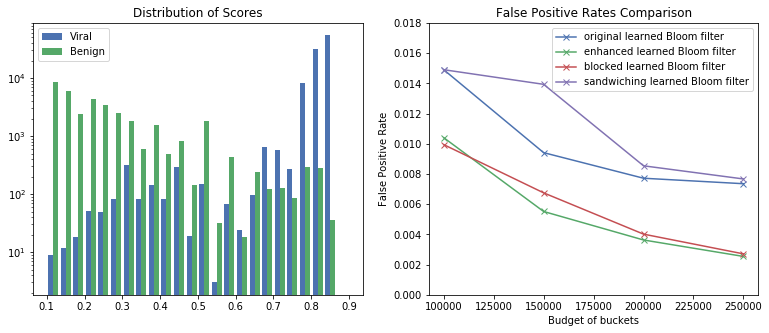

In [36]:
from matplotlib import gridspec

fig = plt.figure(figsize = (13,5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])
ax0 = plt.subplot(gs[0])
# ax0.style.use('seaborn-deep')

x = train_data.loc[train_data.loc[:,'label']==1,'score']
y = train_data.loc[train_data.loc[:,'label']==0,'score']
bins = np.linspace(0.1, 0.9, 25)
ax0.hist([x, y], bins, log=True, label=['Viral', 'Benign'])
ax0.legend(loc='upper left')
ax0.set_title('Distribution of Scores')

ax1 = plt.subplot(gs[1])
ax1.plot([10*10**4, 15*10**4, 20*10**4, 25*10**4], FPR_train['original'], 'x-', label = 'original learned Bloom filter')
ax1.plot([10*10**4, 15*10**4, 20*10**4, 25*10**4], FPR_train['enhanced'], 'x-', label = 'enhanced learned Bloom filter')
ax1.plot([10*10**4, 15*10**4, 20*10**4, 25*10**4], FPR_train['blocked'], 'x-', label = 'blocked learned Bloom filter')
ax1.plot([10*10**4, 15*10**4, 20*10**4, 25*10**4], FPR_train['sandwich'], 'x-', label = 'sandwiching learned Bloom filter')
ax1.set_title('False Positive Rates Comparison')
ax1.legend(loc='upper right')
ax1.set_xticks(np.arange(100000, 260000, 25000))
ax1.set_ylim(0, 0.018)
ax1.set_xlabel('Budget of buckets')
ax1.set_ylabel('False Positive Rate')

fig.savefig('FPR_benchmark.png')